# __Employee Churn Management: Vorhersage der Kündigungswahrscheinlichkeit von Mitarbeitern mithilfe des Random-Forest-Algorithmus__

In [159]:
#Autor: Erol Delismen
#Datum: 31.01.2021

#Laden der Module

#https://docs.python.org/3/library/math.html
import math

#https://numpy.org/doc/stable/reference/
import numpy as np

#https://pandas.pydata.org/docs/reference/index.html
import pandas as pd

#https://seaborn.pydata.org/api.html
import seaborn as sns

#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier

#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree
from sklearn import tree

#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,train_test_split

#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html?highlight=time#sklearn.model_selection.TimeSeriesSplit
from time import time

#https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.SVG
from IPython.display import SVG

#https://graphviz.readthedocs.io/en/stable/api.html#graphviz.Source
from graphviz import Source

#https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html
from sklearn.inspection import plot_partial_dependence

#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

#https://shap.readthedocs.io/en/latest/
import shap

#https://docs.python.org/3/library/itertools.html
import itertools

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot
import matplotlib.pyplot as plt

#https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use("fivethirtyeight") #große Schriften und hoher Kontrast für eine bessere Lesbarkeit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Data understanding

## 1.1 Laden der Daten

In [2]:
#Laden der HR-Daten
df = pd.read_csv("HR_comma_sep_final.csv")

In [3]:
print(df.shape)

(14999, 10)


In [4]:
print('Der Datensatz hat {} Zeilen und {} Spalten'.format(df.shape[0], df.shape[1]))

Der Datensatz hat 14999 Zeilen und 10 Spalten


In [5]:
print('Im Einzelnen handelt es sich um folgende Spalten:')
for column in df.columns:
    print(column)

Im Einzelnen handelt es sich um folgende Spalten:
satisfaction_level
last_evaluation
number_project
average_montly_hours
time_spend_company
Work_accident
left
promotion_last_5years
department
salary


- satisfaction_level: Grad der Mitarbeiterzufriedenheit (Gleitkommazahl im Intervall von [0,1])
- last_evaluation: Grad der letzten Beurteilung (Gleitkommazahl im Intervall von [0-1])
- number_projects: Anzahl der zugewiesenen Projekte je Mitarbeiter (ganzzahlige positive Zahl)
- average_monthly_hours: Die durchschnittlich monatlich geleisteten Stunden je Mitarbeiter (ganzzahlige positive Zahl)
- time_spent_company: Dauer der Betriebszugehörigkeit eines Mitarbeiters im Unternehmen in Jahren (ganzzahlige positive Zahl)
- work_accident: Indikator ob der Mitarbeiter einen Arbeitsunfall hatte (ganzzahlige positive Zahl aus der Menge {0=Nein, 1=Ja})
- promotion_last_5years: Indikator ob der Mitarbeiter in den letzten 5 Jahren befördert wurde (ganzzahlige positive Zahl aus der Menge {0=Nein, 1=Ja})
- department: Bezeichner der beschäftigenden Abteilung/Bereich des Mitarbeiters
- salary: Gehaltsstufe des Mitarbeiters in den Ausprägungen (low = niedrig, medium = mittel, high = hoch)
- left: Indikator ob der Mitarbeiter das Unternehmen verlassen hat (ganzzahlige positive Zahl aus der Menge {0=Nein, 1=Ja})

In [6]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 1.2 Explorative Datenanalyse 

### 1.2.1 Lage- und Streuungsmaße

#### 1.2.1.1 Gesamtdaten

In [7]:
#Statistiken der Gesamtdaten
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


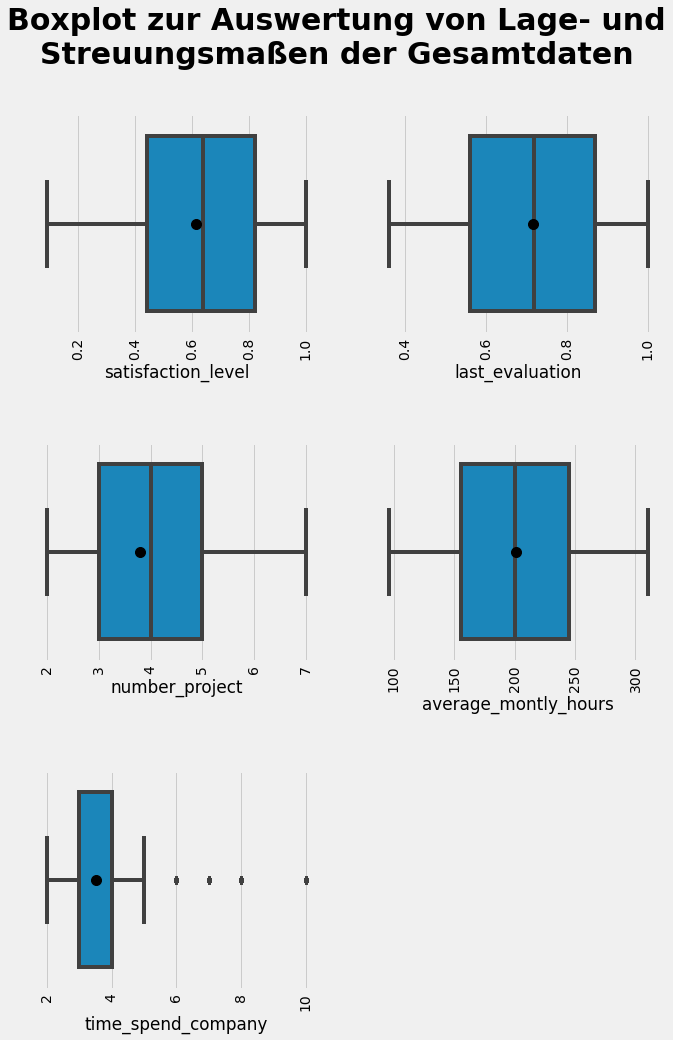

In [8]:
#Boxplot zur Auswertung von Lage- und Streuungsmaßen der Gesamtdaten
features = ['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company']
fig=plt.subplots(figsize=(10,15))
plt.suptitle('Boxplot zur Auswertung von Lage- und\nStreuungsmaßen der Gesamtdaten', fontsize=30, fontweight='extra bold')
length=len(features)
for i,j in itertools.zip_longest(features,range(length)): # itertools.zip_longest for to execute the longest loop
    plt.subplot(int(np.ceil(length/2)),2,j+1)
    plt.subplots_adjust(hspace=.5)
    sns.boxplot(x=i, data = df, showmeans=True,meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black", "markersize":"10"})
    #sns.countplot(x=i,data = df)
    plt.xticks(rotation=90)
    #plt.title("Anzahl der Mitarbeiter")

- Die durchschnittliche Mitarbeiterzufriedenheit liegt bei 61,28%
- Die durchschnittliche Beurteilung liegt bei 71,61%
- Die durchschnittliche Anzahl der Projekte pro MA liegt bei 3,8
- Die durchschnittlichen monatlich geleisteten Arbeitsstunden liegen bei 201h
- Die durchschnittliche Beschäftigungsdauer liegt bei ca. 3,5 Jahren
- Die durchschnittliche Anzahl der Arbeitsunfälle liegt bei 0,144


#### 1.2.1.2 Aufteilung nach Kündiger

In [9]:
#Statistiken für gekündigte Mitarbeiter
df[(df.left==1)].describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.0,3571.000000
mean,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,1.0,0.005321
std,0.263933,0.197673,1.818165,61.202825,0.977698,0.212364,0.0,0.072759
min,0.090000,0.450000,2.000000,126.000000,2.000000,0.000000,1.0,0.000000
25%,0.130000,0.520000,2.000000,146.000000,3.000000,0.000000,1.0,0.000000
50%,0.410000,0.790000,4.000000,224.000000,4.000000,0.000000,1.0,0.000000
75%,0.730000,0.900000,6.000000,262.000000,5.000000,0.000000,1.0,0.000000
max,0.920000,1.000000,7.000000,310.000000,6.000000,1.000000,1.0,1.000000


- Die durchschnittliche Mitarbeiterzufriedenheit liegt bei 44%
- Die durchschnittliche Beurteilung liegt bei 71,8%
- Die durchschnittliche Anzahl der Projekte pro MA liegt bei 3,85
- Die durchschnittlichen monatlich geleisteten Arbeitsstunden liegen bei 207h
- Die durchschnittliche Beschäftigungsdauer liegt bei ca. 3,88 Jahren
- Die durchschnittliche Anzahl der Arbeitsunfälle liegt bei 0,047

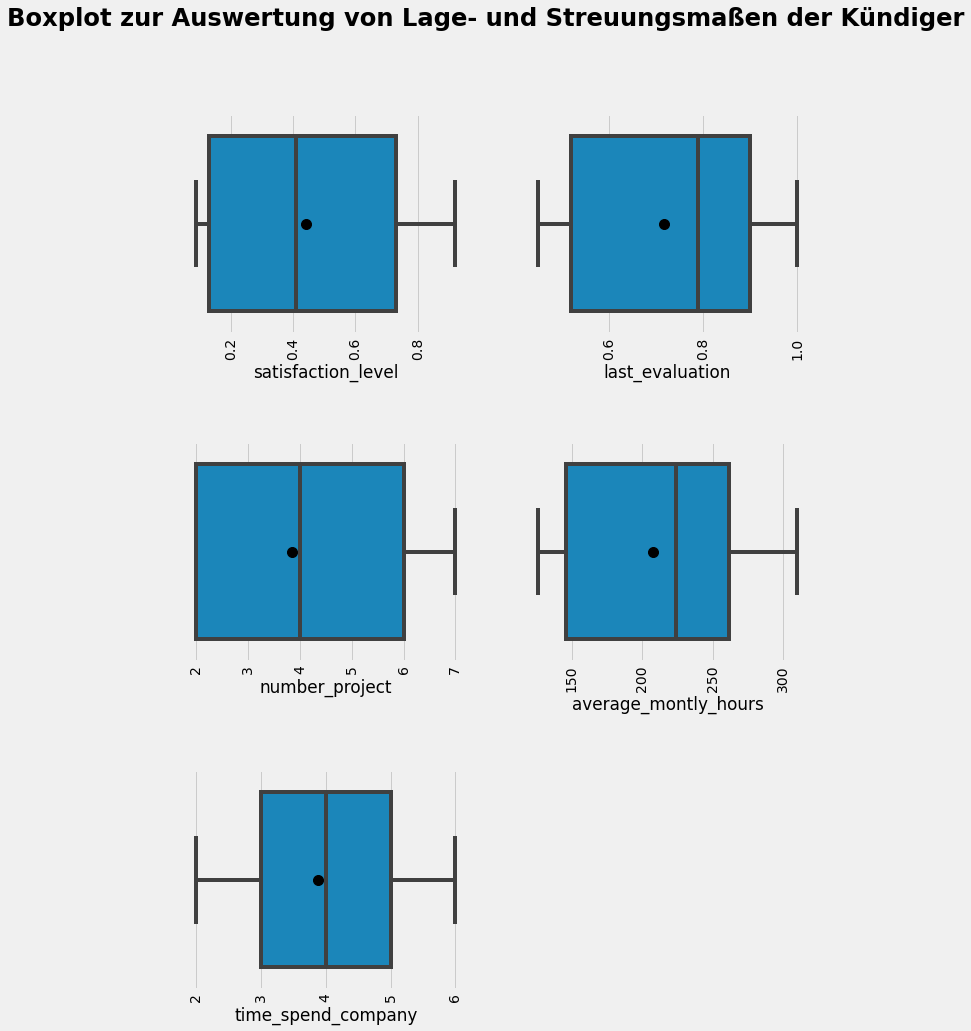

In [10]:
#Boxplot zur Auswertung von Lage- und Streuungsmaßen der Kündiger
features = ['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company']
fig=plt.subplots(figsize=(10,15))
plt.suptitle('Boxplot zur Auswertung von Lage- und Streuungsmaßen der Kündiger', fontsize='xx-large', fontweight='extra bold')
length=len(features)
for i,j in itertools.zip_longest(features,range(length)): # itertools.zip_longest for to execute the longest loop
    plt.subplot(int(np.ceil(length/2)),2,j+1)
    plt.subplots_adjust(hspace=.5)
    sns.boxplot(x=i, data = df[(df.left==1)], showmeans=True,meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black", "markersize":"10"})
    #sns.countplot(x=i,data = df)
    plt.xticks(rotation=90)
    #plt.title("Anzahl der Mitarbeiter")

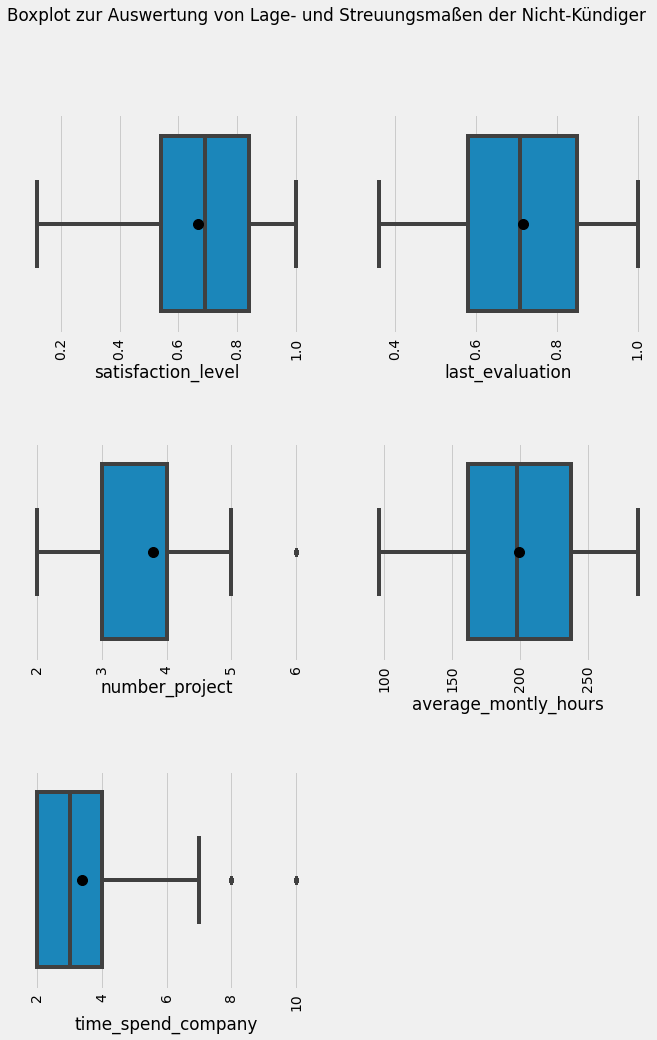

In [11]:
#Boxplot zur Auswertung von Lage- und Streuungsmaßen der Nicht-Kündiger
features = ['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company']
fig=plt.subplots(figsize=(10,15))
plt.suptitle('Boxplot zur Auswertung von Lage- und Streuungsmaßen der Nicht-Kündiger')
length=len(features)
for i,j in itertools.zip_longest(features,range(length)): # itertools.zip_longest for to execute the longest loop
    plt.subplot(int(np.ceil(length/2)),2,j+1)
    plt.subplots_adjust(hspace=.5)
    sns.boxplot(x=i, data = df[(df.left==0)], showmeans=True,meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black", "markersize":"10"})
    #sns.countplot(x=i,data = df)
    plt.xticks(rotation=90)
    #plt.title("Anzahl der Mitarbeiter")

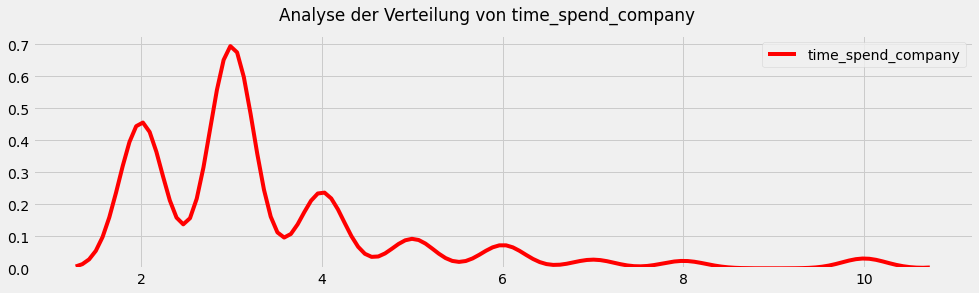

In [12]:
fig = plt.figure(figsize=(15,4),)
plt.suptitle('Analyse der Verteilung von time_spend_company')
ax=sns.kdeplot(df.loc[(df['left']==0),'time_spend_company'], color='r',shade=False, label='time_spend_company')

#### 1.2.1.3 Aufteilung nach Nicht-Kündiger

In [13]:
#Statistiken für nicht-gekündigte Mitarbeiter
df[(df.left==0)].describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,11428.000000,11428.000000,11428.000000,11428.000000,11428.000000,11428.000000,11428.0,11428.000000
mean,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.0,0.026251
std,0.217104,0.162005,0.979884,45.682731,1.562348,0.379991,0.0,0.159889
min,0.120000,0.360000,2.000000,96.000000,2.000000,0.000000,0.0,0.000000
25%,0.540000,0.580000,3.000000,162.000000,2.000000,0.000000,0.0,0.000000
50%,0.690000,0.710000,4.000000,198.000000,3.000000,0.000000,0.0,0.000000
75%,0.840000,0.850000,4.000000,238.000000,4.000000,0.000000,0.0,0.000000
max,1.000000,1.000000,6.000000,287.000000,10.000000,1.000000,0.0,1.000000


- Die durchschnittliche Mitarbeiterzufriedenheit liegt bei 66,68%
- Die durchschnittliche Beurteilung liegt bei 71,54%
- Die durchschnittliche Anzahl der Projekte pro MA liegt bei 3,8
- Die durchschnittlichen monatlich geleisteten Arbeitsstunden liegen bei 199h
- Die durchschnittliche Beschäftigungsdauer liegt bei ca. 3,38 Jahren
- Die durchschnittliche Anzahl der Arbeitsunfälle liegt bei 0,175

In [14]:
#Anzahl/Rel. Anteil der gekündigten Mitarbeiter
print("Anzahl der gekündigten Mitarbeiter: ", len(df[df['left']==1]))
print("Anzahl der ungekündigten Mitarbeiter: ", len(df[df['left']==0]))
print("Relativer Anteil der Kündiger: {:.2%}".format(len(df[df['left']==1])/len(df)))

Anzahl der gekündigten Mitarbeiter:  3571
Anzahl der ungekündigten Mitarbeiter:  11428
Relativer Anteil der Kündiger: 23.81%


### 1.2.2 Verteilung der Mitarbeiter

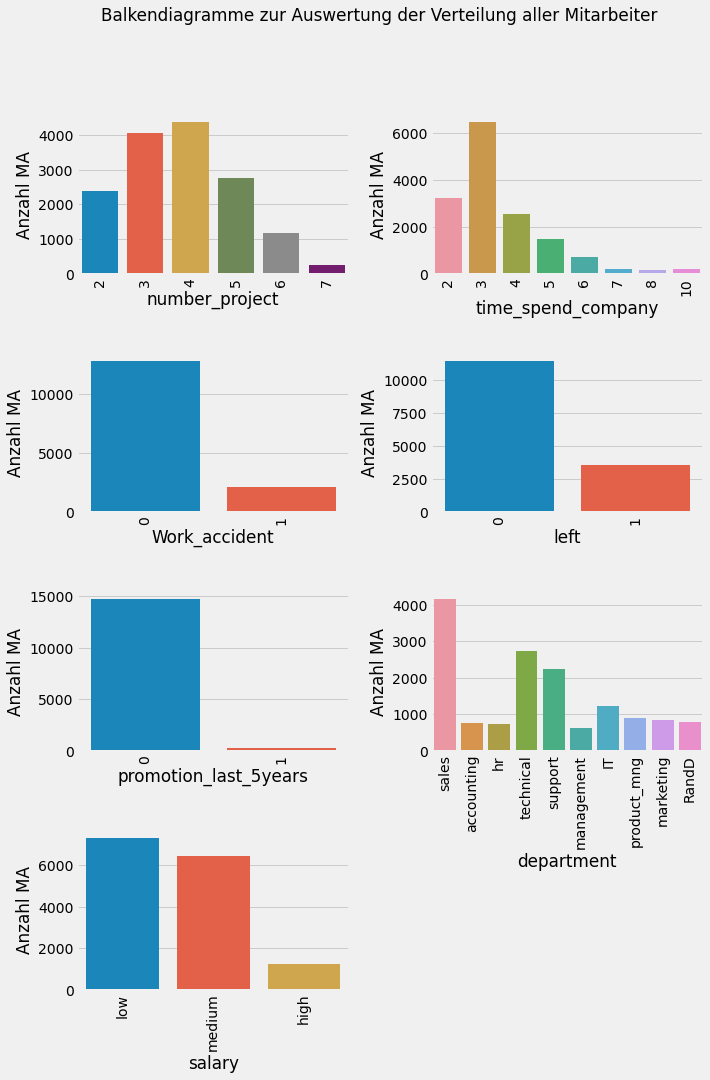

In [15]:
#Balkendiagramme zur Auswertung der Verteilung aller Mitarbeiter
features = ['number_project','time_spend_company','Work_accident','left', 'promotion_last_5years','department','salary']
fig=plt.subplots(figsize=(10,15))
length=len(features)
for i,j in itertools.zip_longest(features,range(length)):
    plt.subplot(int(np.ceil(length/2)),2,j+1)
    plt.subplots_adjust(hspace=.5,wspace=.3)
    sns.countplot(x=i,data = df)
    plt.xticks(rotation=90)
    plt.suptitle('Balkendiagramme zur Auswertung der Verteilung aller Mitarbeiter')
    plt.ylabel('Anzahl MA')

- Die meisten Mitarbeiter arbeiten in 3-5 Projekten.
- Die meisten Mitarbeiter arbeiten mit großem Abstand seit 3 Jahren im Unternehmen (gab es eine Einstellungswelle vor 3 Jahren?). Es gibt einen großen Abfall beim Anteil der Mitarbeiter die 4 Jahre oder länger arbeiten.
- Der relative Anteil der Kündiger beträgt 23.81%.
- Nur ein geringer Anteil der Mitarbeiter wurden befördert.
- Die meisten Mitarbeiter arbeiten im Vertrieb.
- Die meisten Mitarbeiter bekommen ein geringes bzw. mittleres Gehalt.

#### 1.2.2.1 Gegenüberstellung Kündiger zu Nicht-Kündiger in absoluten Zahlen

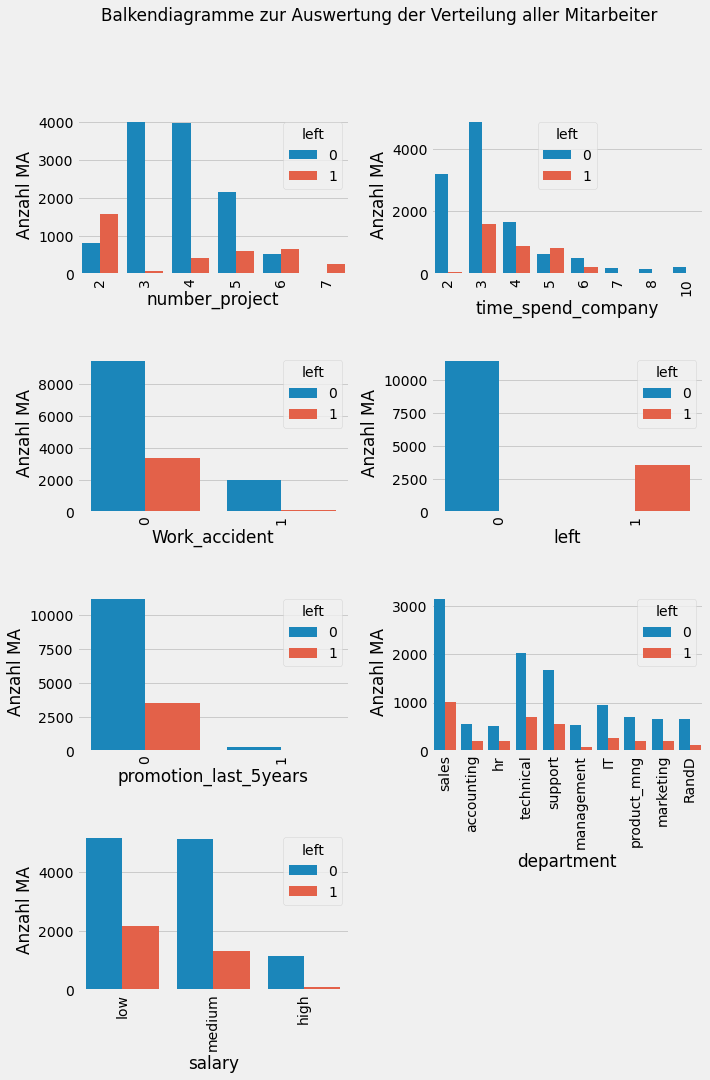

In [16]:
#Balkendiagramme zur Auswertung der Verteilung aller Mitarbeiter
features = ['number_project','time_spend_company','Work_accident','left', 'promotion_last_5years','department','salary']
fig=plt.subplots(figsize=(10,15))
length=len(features)
for i,j in itertools.zip_longest(features,range(length)):
    plt.subplot(int(np.ceil(length/2)),2,j+1)
    plt.subplots_adjust(hspace=.5,wspace=.3)
    sns.countplot(x=i,data = df,hue='left')
    plt.xticks(rotation=90)
    plt.suptitle('Balkendiagramme zur Auswertung der Verteilung aller Mitarbeiter')
    plt.ylabel('Anzahl MA')

- Es gibt keine Kündiger, die mehr als 6 Jahre dabei sind.
- Alle Mitarbeiter, die in 7 Projekten arbeiteten, haben gekündigt.
- Dies führt zu dem Schluss, dass unter den Kündigern möglicherweise Leistungsträger sind.

#### 1.2.2.2 Kündiger in relativen Zahlen

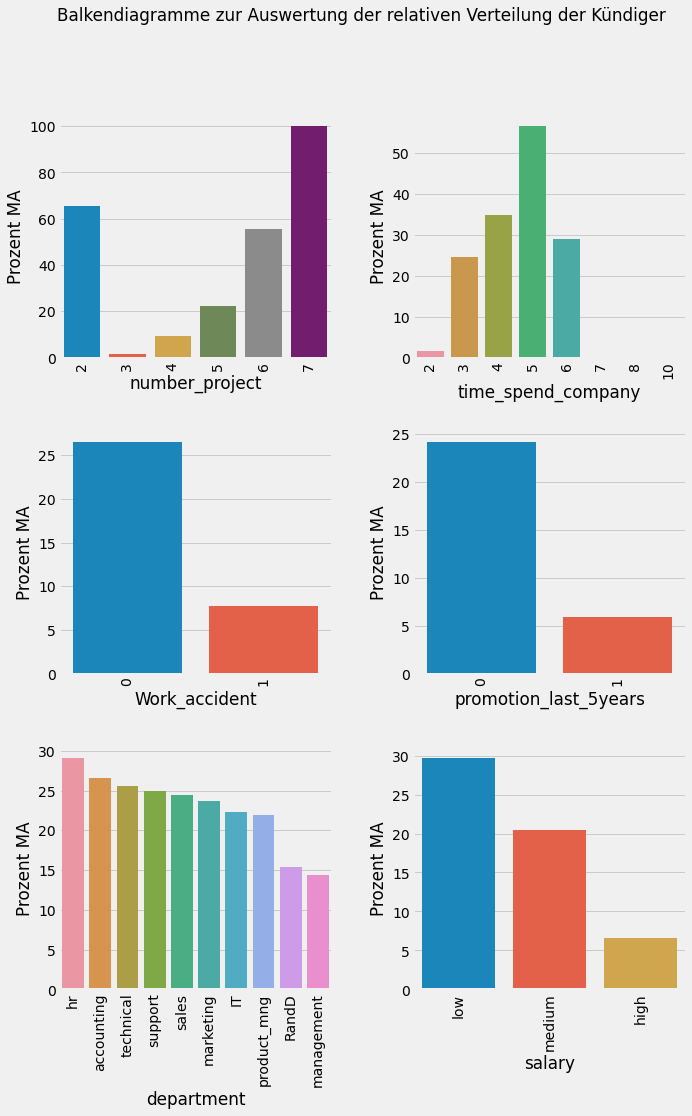

In [17]:
#Balkendiagramme zur Auswertung der relativen Verteilung der Kündiger
features = ['number_project','time_spend_company','Work_accident','promotion_last_5years','department','salary']
fig=plt.subplots(figsize=(10,15))
length=len(features)
for i,j in itertools.zip_longest(features,range(length)):
    Proportion_of_data = df.groupby([i])['left'].agg(lambda x: (x==1).sum()).reset_index()# Zähle nur die Kündiger
    Proportion_of_data1= df.groupby([i])['left'].count().reset_index() # Bilde Gesamtsumme
    Proportion_of_data2 = pd.merge(Proportion_of_data,Proportion_of_data1,on=i) # Merge
    # Pro Feature wird der relative Anteil der Kündiger in Prozent berechnet
    Proportion_of_data2["Proportion"]=(Proportion_of_data2['left_x']/Proportion_of_data2['left_y'])*100 
    Proportion_of_data2=Proportion_of_data2.sort_values(by="Proportion",ascending=False).reset_index(drop=True)#Nach Häufigkeit sortieren
    plt.subplot(int(np.ceil(length/2)),2,j+1)
    plt.subplots_adjust(hspace=.3,wspace=.3)
    sns.barplot(x=i,y='Proportion',data=Proportion_of_data2)
    plt.xticks(rotation=90)
    plt.suptitle('Balkendiagramme zur Auswertung der relativen Verteilung der Kündiger')
    plt.ylabel('Prozent MA')

Text(0, 0.5, 'Anzahl MA')

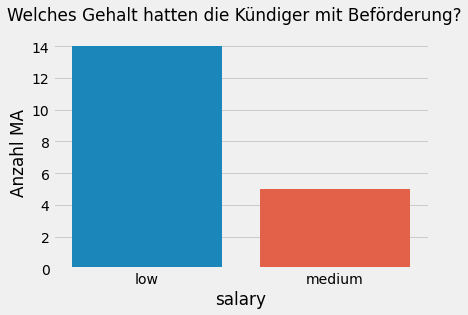

In [18]:
sns.countplot(x='salary',data=df.query('left == 1 & promotion_last_5years==1'))
plt.suptitle('Welches Gehalt hatten die Kündiger mit Beförderung?')
plt.ylabel('Anzahl MA')

- Die Mitarbeiter, die in weniger als 3 (gefeuert?) oder mehr als 5 (überarbeitet?) Projekten arbeiten, verlassen das Unternehmen häufiger. Mitarbeiter mit 7 Projekten verlassen das Unternehmen ausnahmslos.

- Mehr als 50% der Mitarbeiter, die seit 5 Jahren dabei sind, verlassen das Unternehmen. Es fällt auf, dass die Neulinge und die alten Hasen weniger kündigen.

- Ca. 6% (n=19) der Kündiger haben trotz einer Beförderung in den letzten 5 Jahren das Unternehmen verlassen:
    - 14 der Kündiger waren in der Gehaltklasse low verblieben
    - 5 der Kündiger hatten die Gehaltsklasse medium

- Ca. 7.5% der Mitarbeiter, die einen Arbeitsunfall hatten, haben gekündigt. (Gute Entschädigung?)

- Die meisten Kündiger stammen aus den Abteilungen HR, Sachbearbeitung und Technik/Support. Die wenigsten Kündiger stammen aus dem Management.

- Die Mitarbeiter mit geringem oder mittleren Gehalt kündigen häufiger.

#### 1.2.2.3 Analyse der Beförderungen

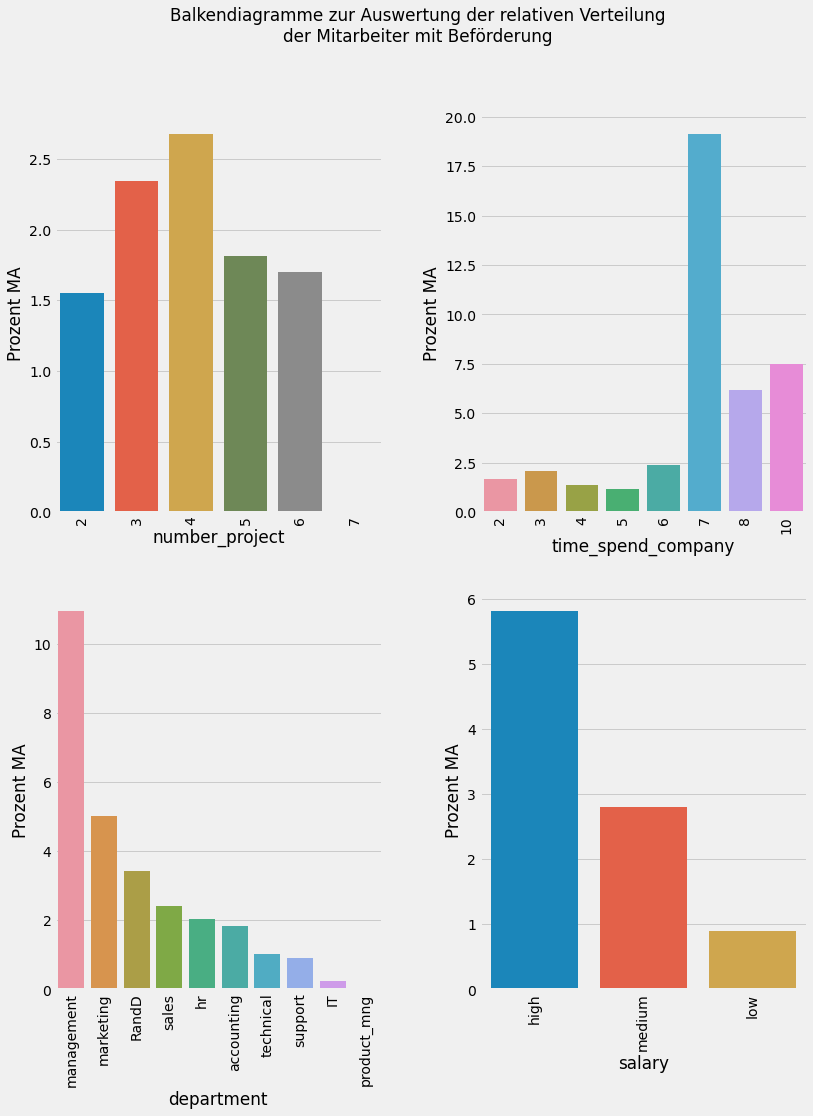

In [19]:
#Balkendiagramme zur Auswertung der relativen Verteilung der Mitarbeiter mit Beförderung
fig=plt.subplots(figsize=(12,15))
features=['number_project','time_spend_company','department','salary']
length=len(features)
for i,j in itertools.zip_longest(features,range(length)):
    Proportion_of_data = df.groupby([i])['promotion_last_5years'].agg(lambda x: (x==1).sum()).reset_index()# Zähle nur die Kündiger 
    Proportion_of_data1= df.groupby([i])['promotion_last_5years'].count().reset_index() # Bilde Gesamtsumme
    Proportion_of_data2 = pd.merge(Proportion_of_data,Proportion_of_data1,on=i) # Merge
    # Pro Feature wird der relative Anteil der Kündiger in Prozent berechnet
    Proportion_of_data2["Proportion"]=(Proportion_of_data2['promotion_last_5years_x']/Proportion_of_data2['promotion_last_5years_y'])*100 
    Proportion_of_data2=Proportion_of_data2.sort_values(by="Proportion",ascending=False).reset_index(drop=True)#Nach Häufigkeit sortieren
    plt.subplot(int(np.ceil(length/2)),2,j+1)
    plt.subplots_adjust(hspace=.2,wspace=.3)
    sns.barplot(x=i,y='Proportion',data=Proportion_of_data2)
    plt.xticks(rotation=90)
    plt.suptitle('Balkendiagramme zur Auswertung der relativen Verteilung\nder Mitarbeiter mit Beförderung')
    plt.ylabel('Prozent MA')

- Mitarbeiter, die in 7 Projekten gearbeitet haben, werden nicht befördert.
- Der größte Anteil der Beförderungen wird an Mitarbeiter mit 7 Jahren Betriebszugehörigkeit (knapp 20%) oder später ausgesprochen.
- Mitarbeiter mit 2-6 Jahren haben verhältnismäßig weniger befördert. Da die meisten Kündigungen in dieser Periode lagen, liegt es nahe, dass sie frustriert waren.
- Mitarbeiter im Management bekommen die meisten Beförderungen (ca. 11%), gefolgt von Marketing (5%) und F&E (3%).
- Mitarbeiter, die schon ein hohes Gehalt bekommen, werden eher befördert (Manager?)

#### 1.2.2.4 Analyse der Arbeitsunfälle

    department  Work_accident_x  Work_accident_y  Proportion
0        RandD              134              787   17.026684
1   management              103              630   16.349206
2    marketing              138              858   16.083916
3      support              345             2229   15.477793
4  product_mng              132              902   14.634146
5        sales              587             4140   14.178744
6    technical              381             2720   14.007353
7           IT              164             1227   13.365933
8   accounting               96              767   12.516297
9           hr               89              739   12.043302


Text(0, 0.5, 'Prozent')

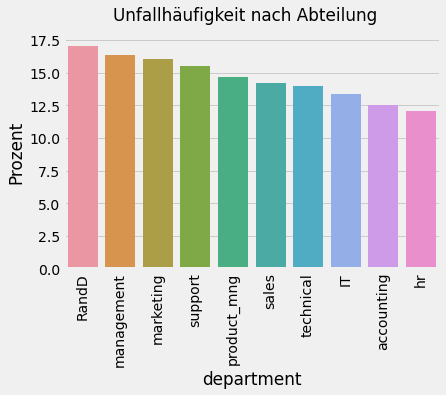

In [20]:
Proportion_of_data = df.groupby(["department"])["Work_accident"].agg(lambda x: (x==1).sum()).reset_index()# Zähle nur die Unfälle 
Proportion_of_data1= df.groupby(["department"])["Work_accident"].count().reset_index() # Bilde Gesamtsumme
Proportion_of_data2 = pd.merge(Proportion_of_data,Proportion_of_data1,on='department') # Merge
# Pro Merkmal wird der relative Anteil der Unfälle in Prozent berechnet
Proportion_of_data2["Proportion"]=(Proportion_of_data2['Work_accident_x']/Proportion_of_data2['Work_accident_y'])*100 
Proportion_of_data2=Proportion_of_data2.sort_values(by="Proportion",ascending=False).reset_index(drop=True)#Nach Häufigkeit sortieren
print(Proportion_of_data2)
sns.barplot(x='department',y='Proportion',data=Proportion_of_data2)
plt.xticks(rotation=90)
plt.suptitle('Unfallhäufigkeit nach Abteilung')
plt.ylabel('Prozent')

Die drei Abteilungen mit den häufigsten Unfällen verteilen sich wie folgt:

- Mitarbeiter aus der Forschung&Entwicklung: 17%
- Mitarbeier aus dem Management: 16.35%
- Mitarbeiter aus dem Marketing: 16,08%

Es ist bemerkenswert, dass Mitarbeiter aus dem Management zu den am häufigsten Verunfallten gehören. Außerdem weisen auch die Abteilungen Sachbearbeitung (12,52%) und HR (12,04%)) eine hohe Quote aus.

## 1.2.3 Clusterung der Daten

Text(0.5, 0.98, 'Mitarbeiterzufriedenheit im Verhältnis zur letzten Beurteilung')

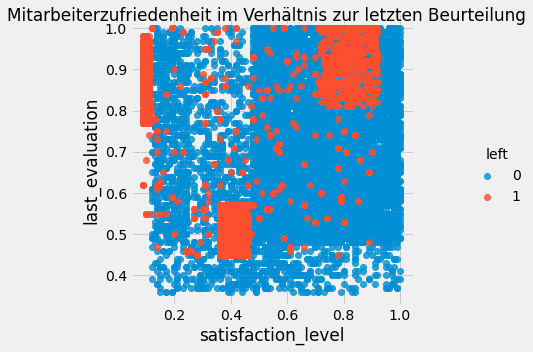

In [21]:
sns.lmplot(x='satisfaction_level', y='last_evaluation', data=df,fit_reg=False,hue='left')
plt.suptitle('Mitarbeiterzufriedenheit im Verhältnis zur letzten Beurteilung')

Es lassen sich drei Cluster von Kündigern unterscheiden:

1. Gute Beurteilung und hohe Zufriedenheit (Häufung im 1. Quadranten)
2. Gute Beurteilung und sehr geringe Zufriedenheit (Häufung im 2. Quadranten)
3. Schlechte Beurteilung und mittlere Zufriedenheit (Häufung im 3. Quadranten)

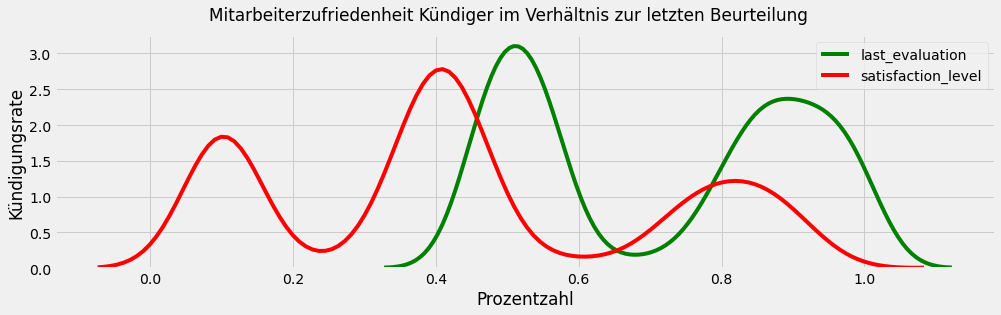

In [22]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['left'] == 1),'last_evaluation'], color='g',shade=False, label='last_evaluation')
ax=sns.kdeplot(df.loc[(df['left'] == 1),'satisfaction_level'], color='r',shade=False, label='satisfaction_level')

ax.set(xlabel='Prozentzahl', ylabel='Kündigungsrate')
plt.suptitle('Mitarbeiterzufriedenheit Kündiger im Verhältnis zur letzten Beurteilung')
plt.legend(loc="upper right")

Die gleiche Clusterung zeigt sich auch im Density Plot:
- Mitarbeiterzufriedenheit ist multimodal und weist drei Peaks auf (=3 Cluster)
- Beurteilung ist bimodal

## 1.2.4 Korrelation von Daten

Text(0.5, 0.98, 'Korrelationsmatrix der einzelnen Merkmale nach Pearson')

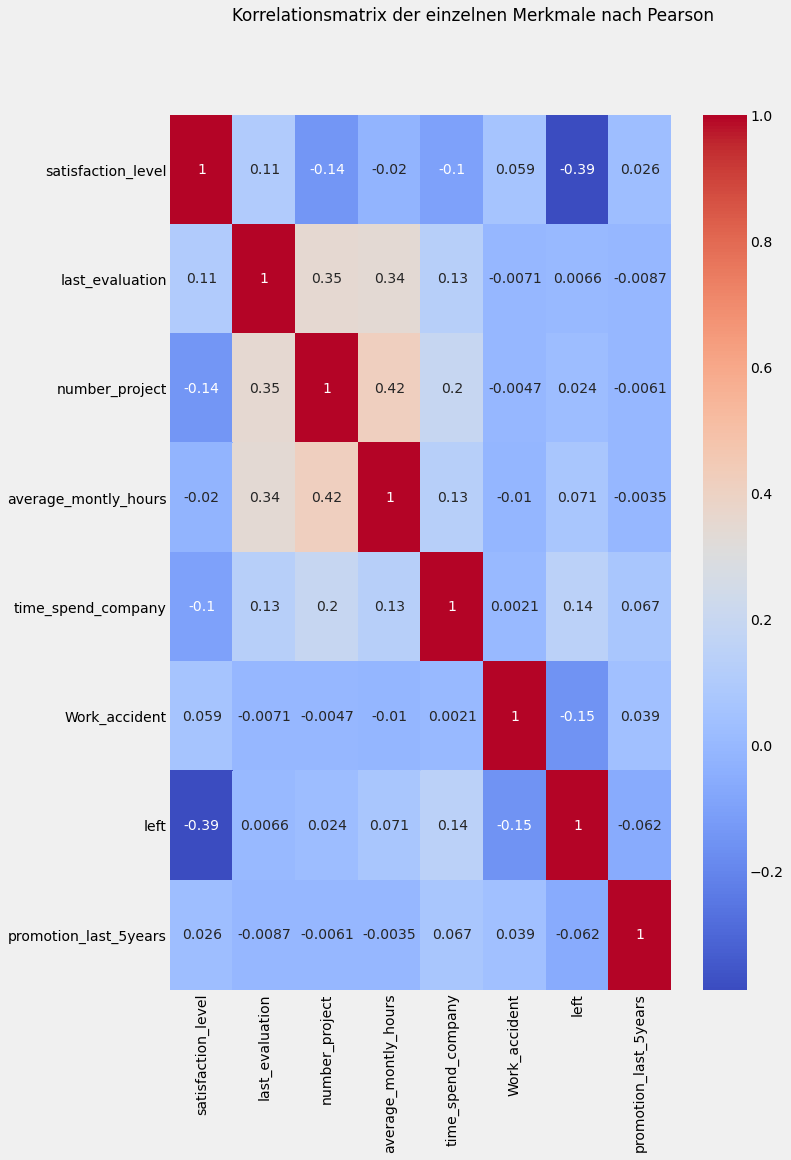

In [23]:
corr= df.corr()
plt.figure(figsize=(10,15))
sns.heatmap(corr,annot=True,cbar=True,cmap="coolwarm")
plt.xticks(rotation=90)
plt.suptitle('Korrelationsmatrix der einzelnen Merkmale nach Pearson')
#plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = True, bottom=False, top = False, labeltop=True)

Es gibt nach den Richtlinien von Cohen (1988) keine hohe Korrelation innerhalb der Daten: eine weitere Reduktion der Dimensionen ist nicht nötig.

- Es gibt eine geringe Korrelation zwischen der Beurteilung und den Arbeitszeiten (0.34) bzw. Anzahl der Projekte (0.35)
- Die Anzahl der Projekte steigt mit der Dauer der Unternehmenszugehörigkeit (0.2)
- Mit steigender Anzahl der Projekte erhöhen sich die Arbeitszeiten (0.42)
- Es gibt eine mittlere negative Korrelation zwischen Kündigern und der Mitarbeiterzufriedenheit (-0.39): je weniger die Zufriedenheit ist, desto eher wird gekündigt.

Text(0.5, 0.98, 'Korrelationsmatrix der einzelnen Merkmale nach Spearman')

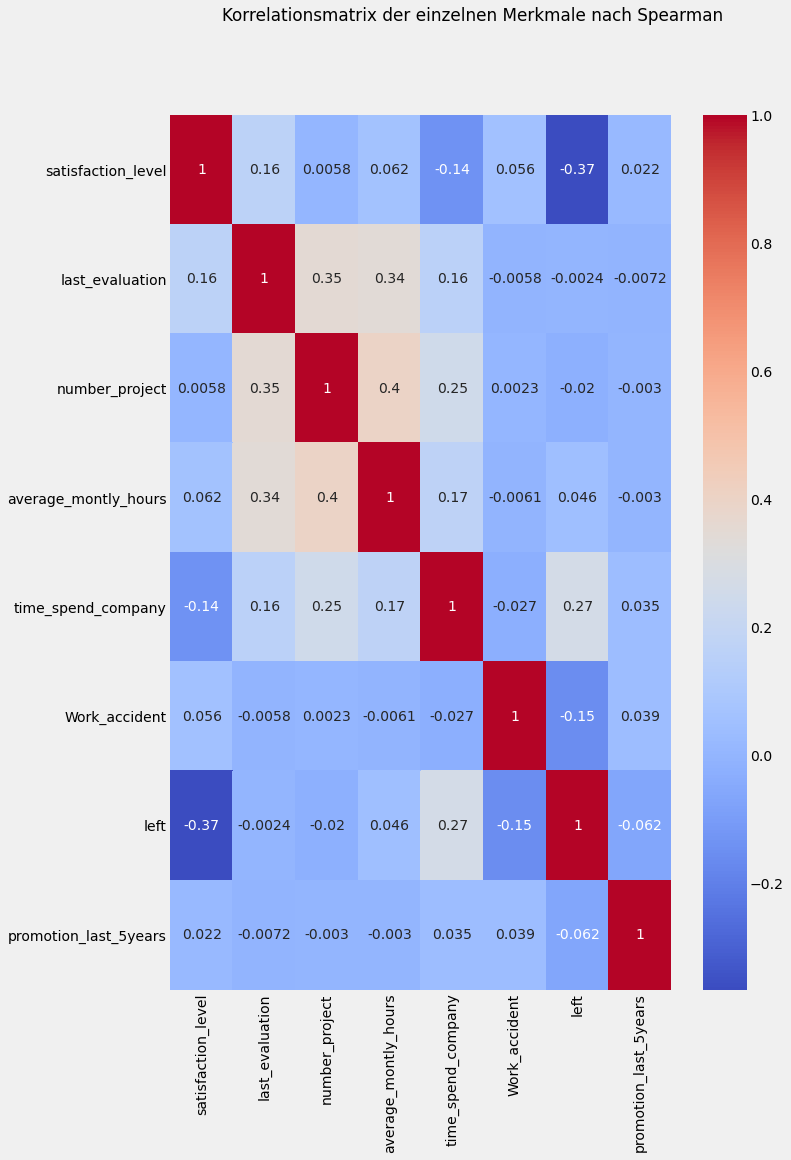

In [24]:
corr= df.corr(method='spearman')
plt.figure(figsize=(10,15))
sns.heatmap(corr,annot=True,cbar=True,cmap="coolwarm")
plt.xticks(rotation=90)
plt.suptitle('Korrelationsmatrix der einzelnen Merkmale nach Spearman')
#plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = True, bottom=False, top = False, labeltop=True)

Die Korrelation nach Spearman weist ebenfalls keine hohen Werte aus.<br>
Es gibt keinen wesentlichen unterschied in den Korrelationskoeffizienten im Vergleich zu Pearson.<br>
Eine weitere Reduktion der Dimensionen ist nicht nötig.

## 1.2.5 Zusammenfassung

Es lassen sich die folgenden Kriterien für eine Kündigung unterscheiden:

- Geringe Mitarbeiterzufriedenheit
- Beschäftigungsdauer von 3-5 Jahren
- Hohe Anzahl von geleisteten Arbeitsstunden (207h) und Anzahl von Projekten (entweder 2 oder mehr als 5-6)
- Mögliche Erkenntniss: Mitarbeiter, die in mehr als 7 Projekten gearbeitet haben, verlassen das Unternehmen, weil sie keine Beförderung bekommen, während Mitarbeiter mit 3-5 Projekten eine Beförderung bekommen.

## 2. Datenaufbereitung

## 2.1 Merkmalsreduktion

### 2.1.1 Zusammenfassung von Abteilungen

Die Abteilungen "IT", "support" und technical werden aufgrund der thematischen Ähnlichkeit zusammengefasst zu "techsupport".

In [25]:
df.replace({'department' : { 'IT' : 'techsupport', 'support' : 'techsupport', 'technical' : 'techsupport' }},inplace=True)

In [26]:
print("Die verbliebenen Abteilungen sehen wie folgt aus:\n")
for dep in df['department'].unique().tolist():
    print(dep)

Die verbliebenen Abteilungen sehen wie folgt aus:

sales
accounting
hr
techsupport
management
product_mng
marketing
RandD


## 2.2 Datentransformation

Das Datenfeld „salary“ wird umgewandelt von einer Nominalskala in eine Ordinalskala. Die
Ausprägungen „low“, „middle“ und „high“ bekommen jeweils die Ausprägung „1“, „2“ bzw.
„3“.

In [27]:
df.replace({'salary' : { 'low' : 1, 'medium' : 2, 'high' : 3 }},inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 1.1+ MB


## 2.3 Behandlung fehlender Werte 

In [29]:
df.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
department               False
salary                   False
dtype: bool

Es gibt keine leeren Felder. (Keine Spalte ist True)

## 2.4 Skalierung von Daten

### 2.4.1 Min-Max-Skalierung (Normalisierung)

Die Daten werden per Min-Max-Skalierung normiert. Die Werte eines numerischen Merkmals
werden zwischen dem Minimum und dem Maximum dieses Merkmals skaliert. Das
Merkmal „left“ wird hierbei ausgelassen, da es bereits skaliert ist. Das Merkmal „department“
wird ebenfalls ausgelassen, da es sich nicht um einen numerischen Wert handelt.

In [30]:
features = [x for x in df.columns if x not in ['department','left']]

In [31]:
features

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years',
 'salary']

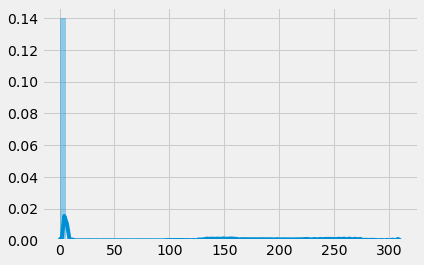

In [32]:
sns.distplot(df[df.columns.difference(['department','left'])], kde = True, hist=True);

In [33]:
df_x = df[features]

In [34]:
df_x.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
0,0.38,0.53,2,157,3,0,0,1
1,0.80,0.86,5,262,6,0,0,2
2,0.11,0.88,7,272,4,0,0,2
3,0.72,0.87,5,223,5,0,0,1
4,0.37,0.52,2,159,3,0,0,1


In [35]:
df_x.corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,0.025605,0.050022
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,-0.008684,-0.013002
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,-0.006064,-0.001803
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,-0.003544,-0.002242
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.067433,0.048715
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,0.039245,0.009247
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,1.000000,0.098119
salary,0.050022,-0.013002,-0.001803,-0.002242,0.048715,0.009247,0.098119,1.000000


In [36]:
minmax_scaler = MinMaxScaler()
df_minmax_scal = minmax_scaler.fit_transform(df_x)
df_minmax_scal = pd.DataFrame(df_minmax_scal, columns=features)

In [37]:
df_minmax_scal.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
0,0.318681,0.265625,0.0,0.285047,0.125,0.0,0.0,0.0
1,0.780220,0.781250,0.6,0.775701,0.500,0.0,0.0,0.5
2,0.021978,0.812500,1.0,0.822430,0.250,0.0,0.0,0.5
3,0.692308,0.796875,0.6,0.593458,0.375,0.0,0.0,0.0
4,0.307692,0.250000,0.0,0.294393,0.125,0.0,0.0,0.0


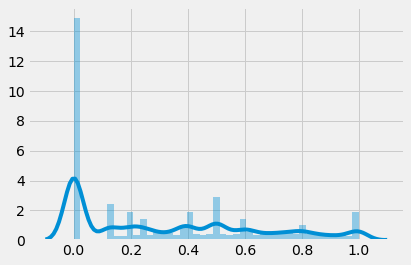

In [38]:
sns.distplot(df_minmax_scal, kde = True, hist=True);

In [39]:
df_minmax_scal.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.574542,0.556409,0.360611,0.490889,0.187279,0.144610,0.021268,0.297353
std,0.273220,0.267452,0.246518,0.233379,0.182517,0.351719,0.144281,0.318591
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.200000,0.280374,0.125000,0.000000,0.000000,0.000000
50%,0.604396,0.562500,0.400000,0.485981,0.125000,0.000000,0.000000,0.500000
75%,0.802198,0.796875,0.600000,0.696262,0.250000,0.000000,0.000000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.4 One-Hot-Kodierung

Das Merkmal „department“ wird per One-Hot-Kodierung in Dummy-Variablen aufgeteilt.

In [40]:
df_dummy = pd.get_dummies(df[['department','left']])

In [41]:
df_dummy.head() # Da mehrere Spalten betroffen sind, werden jeweils Präfixe eingeführt

,left,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_techsupport
0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0


In [42]:
dta = df_minmax_scal.copy()
dta.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
0,0.318681,0.265625,0.0,0.285047,0.125,0.0,0.0,0.0
1,0.780220,0.781250,0.6,0.775701,0.500,0.0,0.0,0.5
2,0.021978,0.812500,1.0,0.822430,0.250,0.0,0.0,0.5
3,0.692308,0.796875,0.6,0.593458,0.375,0.0,0.0,0.0
4,0.307692,0.250000,0.0,0.294393,0.125,0.0,0.0,0.0


In [43]:
dta.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
0,0.318681,0.265625,0.0,0.285047,0.125,0.0,0.0,0.0
1,0.780220,0.781250,0.6,0.775701,0.500,0.0,0.0,0.5
2,0.021978,0.812500,1.0,0.822430,0.250,0.0,0.0,0.5
3,0.692308,0.796875,0.6,0.593458,0.375,0.0,0.0,0.0
4,0.307692,0.250000,0.0,0.294393,0.125,0.0,0.0,0.0


In [44]:
dta = pd.concat([dta, df_dummy], axis = 1) #Zusammenführen der Daten

In [45]:
dta.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_techsupport
0,0.318681,0.265625,0.0,0.285047,0.125,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0
1,0.780220,0.781250,0.6,0.775701,0.500,0.0,0.0,0.5,1,0,0,0,0,0,0,1,0
2,0.021978,0.812500,1.0,0.822430,0.250,0.0,0.0,0.5,1,0,0,0,0,0,0,1,0
3,0.692308,0.796875,0.6,0.593458,0.375,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0
4,0.307692,0.250000,0.0,0.294393,0.125,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0


## 2.5 Hauptkomponentenanalyse (PCA)

Es wird eine Hauptkomponentenanalyse (PCA) des Datensatzes durchgeführt.

In [46]:
predictors = [x for x in dta.columns if x not in ['left']]
X = dta[predictors]
y = dta.left

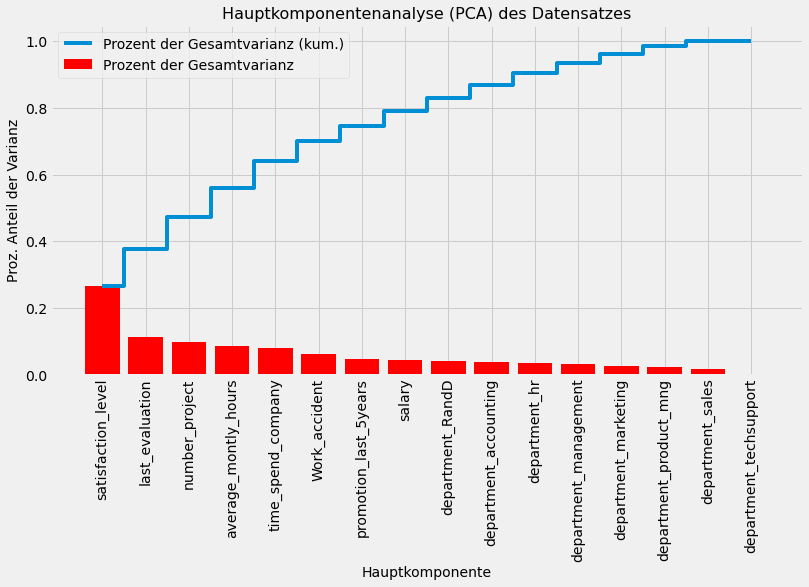

In [47]:
# Build PCA using standarized trained data

pca = PCA(n_components=None, svd_solver="full")
pca.fit(X)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(predictors)+1), pca.explained_variance_ratio_, align="center",
        color='red', label="Prozent der Gesamtvarianz")
plt.step(range(1, len(predictors)+1), cum_var_exp, where="mid", label="Prozent der Gesamtvarianz (kum.)")
plt.xticks(range(1, len(predictors)+1), predictors, rotation='vertical')
plt.legend(loc="best")
plt.xlabel("Hauptkomponente", {"fontsize": 14})
plt.ylabel("Proz. Anteil der Varianz", {"fontsize": 14})
plt.title("Hauptkomponentenanalyse (PCA) des Datensatzes", {"fontsize": 16});

Ergebnis: Die kummulative Varianz wird zu ca. 98% durch 14 Hauptkomponenten erklärt,
somit ist keine weitere Reduzierung der Dimensionen nötig.

## 2.5 Aufteilen des Datensatzes in eine Trainings- und Testmenge

Der Datensatz wird aufgeteilt in eine Trainings- und Testdatenmenge. Die Aufschlüsselung
erfolgt nach dem Verhältnis 30:70, also 30% Testdaten und 70% Trainingsdaten. Die Inputdaten
werden dabei aufgebrochen in eine Menge des Targets Y (Left: Binäre Klasse
J/N) und Features X (alle übrigen Merkmale).

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    shuffle = True, #Durchmischen der Daten vor der Trennung
                                                    stratify = y, #Beibehaltung der Quote erfolgreich zu nicht-erfolgreich in Training- und Testdatensatz
                                                    random_state = 4711)

In [49]:
print('Shape Trainingsdatensatz: ', X_train.shape)
print('Shape Testdatensatz: ', X_test.shape)

Shape Trainingsdatensatz:  (10499, 16)
Shape Testdatensatz:  (4500, 16)


In [50]:
X_train.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_techsupport
count,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000
mean,0.574394,0.557508,0.363063,0.493509,0.186470,0.146300,0.021716,0.295504,0.052672,0.048957,0.048576,0.043052,0.058006,0.060387,0.274502,0.413849
std,0.274680,0.266518,0.246251,0.233660,0.182184,0.353423,0.145763,0.319099,0.223388,0.215789,0.214990,0.202983,0.233765,0.238213,0.446284,0.492546
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.384615,0.312500,0.200000,0.280374,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.604396,0.562500,0.400000,0.490654,0.125000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.802198,0.796875,0.600000,0.696262,0.250000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
print("Anzahl der Features: ", len(predictors))

Anzahl der Features:  16


## 3. Modellierung

Es wird zunächst ein Modell mit Default-Werten trainiert

In [152]:
modell_default = RandomForestClassifier(n_estimators=100)
modell_default.fit(X_train, y_train)
print("Score: ", modell_default.score(X_test, y_test))
print("Die durchschnittliche Klassifikationsgenauigkeit liegt bei {:.3%}".format(modell_default.score(X_test, y_test)))

Score:  0.9906666666666667
Die durchschnittliche Klassifikationsgenauigkeit liegt bei 99.067%


## 3.1 Hyperparameteroptimierung mit RandomizedSearchCV

Zu Vorbereitung eines RandomizedSearchCV wird ein Parametergrid erstellt mit den folgenden Parametern:

- n_estimators: __1000__ (Anzahl der Bäume, *Standardwert=100*)
- criterion: __{“gini”}__ (Gini-Koeffizient als Homogenitätsmaß eines Splits, *Standardwert=gini*)
- min_samples_split: __0 bis 3__ (Anzahl der Samples pro inneren Knoten, damit sie gesplittet werden dürfen, *Standardwert=2*)
- min_samples_leaf: __0 oder 3__ (Anzahl der Samples, die ein Blatt besitzen muss, um valide zu sein, *Standardwert=1*)
- bootstrap: __True__ (Bootstrap Aggregation der Trainingsdaten, *Standardwert=True*)
- warm_start: __True__ (Vorherige Bäume sollen beim Fitten beibehalten werden, *Standardwert=False*)
- max_features: __4 bis 10__ (Die max. zu betrachtenden Features pro Split, *Standardwert=auto*)
- max_depth: __1 bis 29__ (Die max. Tiefe eines Baums im Ensemble, *Standardwert=None*)
- oob_score: __True__ (Der laufende Score wird mit einem Out-of-Bag-Sample validiert, *Standardwert=False*)
- min_impurity_decrease: __0,0 bzw. 0,01 bzw 0,05__ (Schwellwert für Abnahme der Unreinheit, damit gesplitte wird, *Standardwert=0.0*)

In [184]:
param_list = {
    'n_estimators': [1000],
    'criterion': ['gini'],
    'min_samples_split': range(0,4),
    'min_samples_leaf': range(0,4),
    'bootstrap': [True],
    'warm_start': [True],
    'max_features': list(range(4,11)),
    'max_depth': range(1,30),
    'oob_score': [True],
    'min_impurity_decrease': [0.0, 0.01, 0.05]
}
print(param_list)

{'n_estimators': [1000], 'criterion': ['gini'], 'min_samples_split': range(0, 4), 'min_samples_leaf': range(0, 4), 'bootstrap': [True], 'warm_start': [True], 'max_features': [4, 5, 6, 7, 8, 9, 10], 'max_depth': range(1, 30), 'oob_score': [True], 'min_impurity_decrease': [0.0, 0.01, 0.05]}


Sonstige Parameter, die nicht explizit betrachtet bzw. angegeben werden, für die die folgenden __Standardwerte__ angenommen werden:

- min_weight_fraction_leaf: __0.0__
- max_leaf_nodes: __None__
- min_impurity_split: __None__
- verbose: __0__
- class_weight: __None__
- ccp_alpha: __0.0__
- max_samples: __None__

In [185]:
start = time()

gridSearch = GridSearchCV(modell_default,
                     param_grid = param_list,
                     scoring = 'accuracy',
                     n_jobs=-1,
                     cv = 10,
                     refit = True,
                     verbose = 2)

search = gridSearch.fit(X_train, y_train)
search.best_params_

Fitting 10 folds for each of 9744 candidates, totalling 97440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 19,
 'max_features': 5,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000,
 'oob_score': True,
 'warm_start': True}

In [186]:
print("GridSearchCV brauchte %.2f Sekunden für %d Einstellkombinationen."
      % (time() - start, len(gridSearch.cv_results_['params'])))

GridSearchCV brauchte 33690.67 Sekunden für 9744 Einstellkombinationen.


In [187]:
#Mean cross-validated score of the best_estimator
print("Durchschnittlicher kreuzvalidierter Score des besten Estimators = ", search.best_score_)

print("Güte des Modells anhand der Trainingsdaten: {:.3%}".format(search.score(X_train, y_train)))
print("Güte des Modells anhand der Testdaten: {:.3%}".format(search.score(X_test, y_test)))

Durchschnittlicher kreuzvalidierter Score des besten Estimators =  0.9912373689227836
Güte des Modells anhand der Trainingsdaten: 100.000%
Güte des Modells anhand der Testdaten: 99.111%


In [188]:
print("Die beste Parameterkombination ist:\n")
for kombi, wert in search.best_params_.items():
    print("%s: %s" % (kombi, wert))

Die beste Parameterkombination ist:

bootstrap: True
criterion: gini
max_depth: 19
max_features: 5
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 1000
oob_score: True
warm_start: True


## 3.2 Trainieren des finalen Modells

In [191]:
modell_final = RandomForestClassifier(warm_start = True,
                            random_state = 4711,
                            n_jobs = -1,
                            n_estimators = 1000, 
                            min_samples_split = 2, 
                            min_samples_leaf = 1,
                            max_features = 5,
                            criterion = 'gini',
                            max_depth = 19,
                            min_impurity_decrease = 0.0,
                            oob_score = True,
                            bootstrap = True)

clf = modell_final.fit(X_train, y_train)

In [194]:
print("Score: ", modell_final.score(X_test, y_test))
print("Güte des Modells anhand der Trainingsdaten: {:.3%}".format(modell_final.score(X_train, y_train)))
print("Güte des Modells anhand der Testdaten: {:.3%}".format(modell_final.score(X_test, y_test)))

Score:  0.9913333333333333
Güte des Modells anhand der Trainingsdaten: 100.000%
Güte des Modells anhand der Testdaten: 99.133%


In [195]:
tree_rules_0 = export_text(clf.estimators_[0], feature_names=list(X.columns))
print("Ausgabe eines der erstellten Bäume\n", tree_rules_0)

Ausgabe eines der erstellten Bäume
 |--- time_spend_company <= 0.06
|   |--- last_evaluation <= 0.48
|   |   |--- average_montly_hours <= 0.61
|   |   |   |--- class: 0.0
|   |   |--- average_montly_hours >  0.61
|   |   |   |--- last_evaluation <= 0.30
|   |   |   |   |--- class: 0.0
|   |   |   |--- last_evaluation >  0.30
|   |   |   |   |--- average_montly_hours <= 0.61
|   |   |   |   |   |--- satisfaction_level <= 0.91
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- satisfaction_level >  0.91
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- average_montly_hours >  0.61
|   |   |   |   |   |--- Work_accident <= 0.50
|   |   |   |   |   |   |--- satisfaction_level <= 0.31
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- satisfaction_level >  0.31
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Work_accident >  0.50
|   |   |   |   |   |   |--- class: 0.0
|   |--- last_evaluation >  0.48
|   |   |--- last_eval

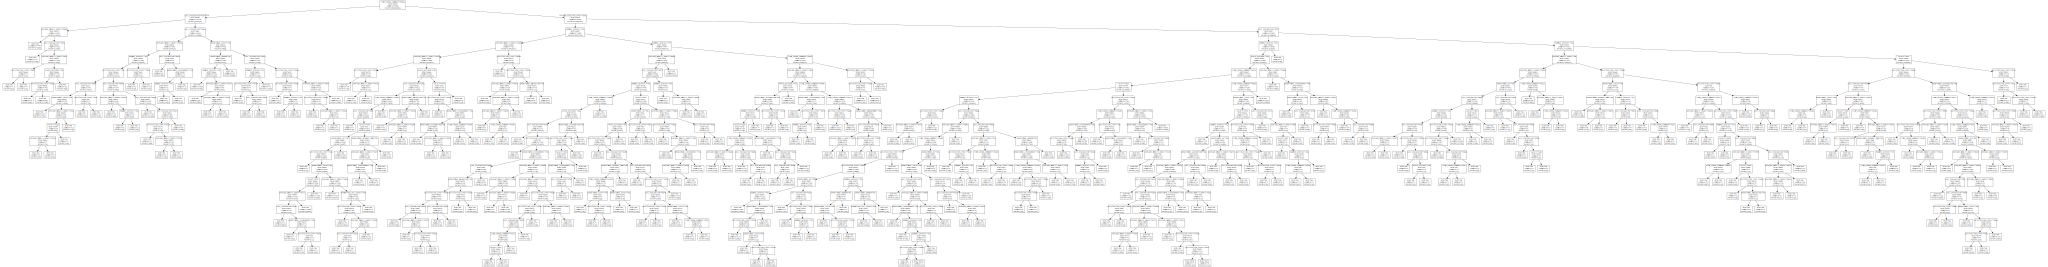

In [196]:
graph = Source( tree.export_graphviz(clf.estimators_[0], out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

In [197]:
results = X_test.copy()

results['left'] = y_test
results['prediction'] = clf.predict(X_test)
results['probability'] = clf.predict_proba(X_test)[:,1]

In [198]:
results.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_techsupport,left,prediction,probability
283,0.010989,0.890625,0.8,0.901869,0.250,1.0,0.0,0.0,0,0,0,0,0,0,0,1,1,1,0.999000
4248,0.472527,0.171875,0.8,0.210280,0.375,1.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0.021045
4482,0.461538,0.484375,0.4,0.616822,0.125,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0.003093
13610,0.461538,0.953125,0.4,0.757009,0.000,0.0,0.0,0.5,0,0,0,0,0,0,1,0,0,0,0.002803
10994,0.571429,0.781250,0.2,0.668224,0.125,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0.001130


In [199]:
results['tree0_probability'] = clf.estimators_[0].predict_proba(X_test)[:,1]
results['tree1_probability'] = clf.estimators_[1].predict_proba(X_test)[:,1]

In [200]:
results['probability_tree_mean'] = (results['tree0_probability'] + results['tree1_probability']) / 2

In [201]:
results.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,department_RandD,department_accounting,...,department_marketing,department_product_mng,department_sales,department_techsupport,left,prediction,probability,tree0_probability,tree1_probability,probability_tree_mean
283,0.010989,0.890625,0.8,0.901869,0.250,1.0,0.0,0.0,0,0,...,0,0,0,1,1,1,0.999000,1.0,1.0,1.0
4248,0.472527,0.171875,0.8,0.210280,0.375,1.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0.021045,0.0,0.0,0.0
4482,0.461538,0.484375,0.4,0.616822,0.125,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0.003093,0.0,0.0,0.0
13610,0.461538,0.953125,0.4,0.757009,0.000,0.0,0.0,0.5,0,0,...,0,0,1,0,0,0,0.002803,0.0,0.0,0.0
10994,0.571429,0.781250,0.2,0.668224,0.125,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0.001130,0.0,0.0,0.0


## 4. Evaluation

## 4.1 Modellmetriken

### 4.1.1 Konfusionsmatrix

Text(0.5, 13.779999999999973, 'Modellprognose')

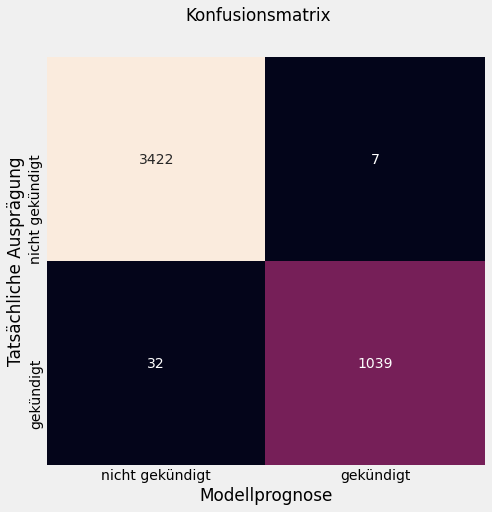

In [202]:
cm = confusion_matrix(results['left'], results['prediction'])
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=['nicht gekündigt','gekündigt'], yticklabels = ['nicht gekündigt','gekündigt'])
plt.suptitle('Konfusionsmatrix')
plt.ylabel('Tatsächliche Ausprägung')
plt.xlabel('Modellprognose')

In [203]:
print('Richtig Positiv (RP):', cm[1][1])
print('Falsch Positiv (FP):', cm[0][1])
print('Falsch Negativ (FN):', cm[1][0])
print('Richtig Negativ (RN):', cm[0][0])

Richtig Positiv (RP): 1039
Falsch Positiv (FP): 7
Falsch Negativ (FN): 32
Richtig Negativ (RN): 3422


### 4.1.2 Accuracy (Klassifikationsgenauigkeit)

In [204]:
accuracy = accuracy_score(results['left'], results['prediction'])
print('Accuracy (Klassifikationsgenauigkeit):', accuracy)
print('{:.2%} der Mitarbeiter werden richtig klassifiziert.'.format(accuracy))

Accuracy (Klassifikationsgenauigkeit): 0.9913333333333333
99.13% der Mitarbeiter werden richtig klassifiziert.


### 4.1.3 Falschklassifikationsrate

In [205]:
falschklassifikationsrate = 1 - accuracy
print('Falschklassifikationsrate:', falschklassifikationsrate)
print('{:.2%} der Mitarbeiter werden falsch klassifiziert.'.format(falschklassifikationsrate))

Falschklassifikationsrate: 0.008666666666666711
0.87% der Mitarbeiter werden falsch klassifiziert.


### 4.1.4 Präzision (Precision)

In [206]:
precision = precision_score(results['left'], results['prediction'])
print('Präzision (Precision):', precision)
print('Von den {0} prognostizierten Kündigern wurden {1:.2%}, also {2}, richtig klassifiziert.'.format((cm[1][1] + cm[0][1]), precision, cm[1][1]))

Präzision (Precision): 0.9933078393881453
Von den 1046 prognostizierten Kündigern wurden 99.33%, also 1039, richtig klassifiziert.


### 4.1.5 Sensitivität (Recall)

In [207]:
recall = recall_score(results['left'], results['prediction'])
print('Sensitivität (Recall):', recall)
print('Von den {0} tatsächlich gekündigten Mitarbeitern wurden {1:.2%}, also {2}, richtig klassifiziert.'.format((cm[1][1] + cm[1][0]),recall,cm[1][1]))

Sensitivität (Recall): 0.9701213818860878
Von den 1071 tatsächlich gekündigten Mitarbeitern wurden 97.01%, also 1039, richtig klassifiziert.


### 4.1.6 F-Maß

In [208]:
fscore = 2 * precision * recall / (precision + recall)
print('F-Maß:', fscore)

F-Maß: 0.9815777042985356


### 4.1.7 Falsch-Positiv-Rate

In [209]:
false_positive_rate = (cm[0][1] / (cm[0][1] + cm[0][0]))
print('Falsch-positiv-Rate (false positive rate)):', false_positive_rate)
print('Von den {0} nicht gekündigten Mitarbeitern wurden {1:.2%}, also {2} fälschlicherweise als gekündigt klassifiziert.'.format((cm[0][1] + cm[0][0]),false_positive_rate,cm[0][1]))

Falsch-positiv-Rate (false positive rate)): 0.002041411490230388
Von den 3429 nicht gekündigten Mitarbeitern wurden 0.20%, also 7 fälschlicherweise als gekündigt klassifiziert.


### 4.1.8 Area under the Curve (AUC) und Receiver Operating Characteristic (ROC)

In [210]:
auc = roc_auc_score(results['left'], results['probability'])
print('AUC:', auc)

AUC: 0.9942730470238063


AUC: 0.9942730470238063


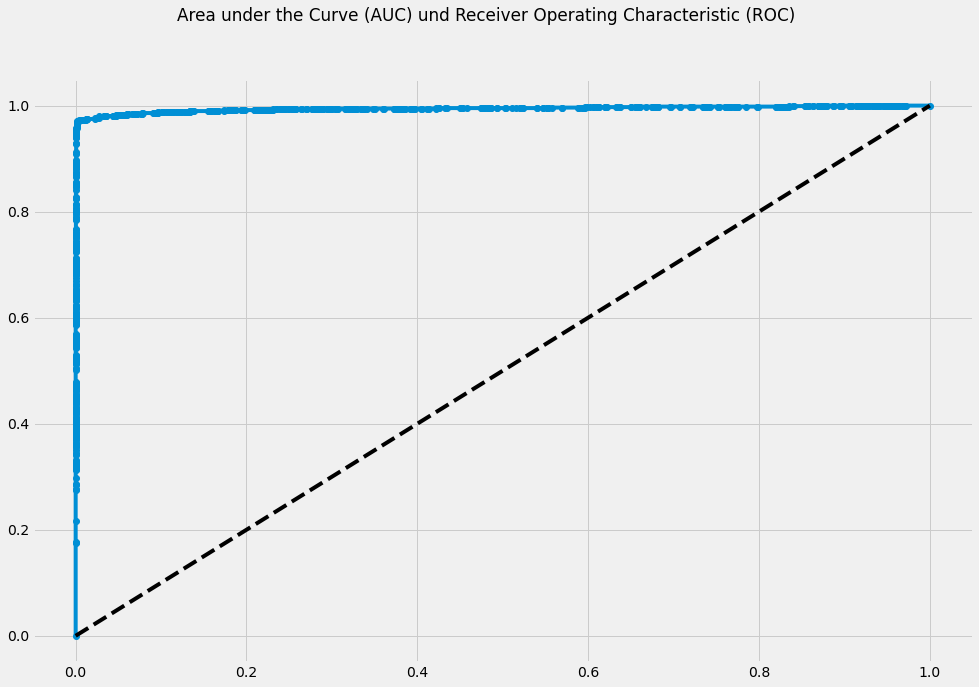

In [211]:
auc = roc_auc_score(results['left'], results['probability'])
print('AUC:', auc)

fpr, tpr, thresholds = roc_curve(results['left'], results['probability'])

plt.subplots(figsize=(15, 10))
plt.suptitle('Area under the Curve (AUC) und Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, 'o-', label="ROC-Kurve "+" "+"(AUC: %0.2f)" %auc, fillstyle='full')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color = 'black', linestyle='dashed', label="AUC 0.5")

## 4.2 Feature Importance

Feature ranking (Importance in percentage):
1. satisfaction_level (33.85%)
2. time_spend_company (18.75%)
3. number_project (17.49%)
4. average_montly_hours (14.89%)
5. last_evaluation (11.93%)
6. salary (0.96%)
7. Work_accident (0.67%)
8. department_techsupport (0.37%)
9. department_sales (0.30%)
10. department_management (0.13%)
11. department_accounting (0.13%)
12. department_hr (0.13%)
13. promotion_last_5years (0.11%)
14. department_RandD (0.10%)
15. department_marketing (0.10%)
16. department_product_mng (0.07%)


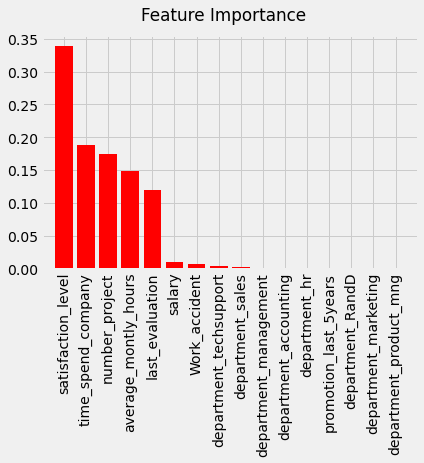

In [212]:
#Combine array of feature_importances_ and feature names
importances = sorted(list(zip(X_test.columns,clf.feature_importances_,range(X_test.shape[1]))),key=lambda tup: tup[1], reverse=True)

#Calculate the per feature standard deviation
std = np.std([clf.feature_importances_ for tree in clf.estimators_],
             axis=0)

#Transpose array
importances = pd.DataFrame(importances).T.values.tolist()

# Print the feature ranking
print("Feature ranking (Importance in percentage):")

for f in range(X_test.shape[1]):
    print("%d. %s (%.2f%%)" % (f + 1, importances[0][f], 100 * importances[1][f]))
    


# Plot the impurity-based feature importances of the forest
plt.figure()
plt.suptitle("Feature Importance")
plt.bar(range(X_test.shape[1]), importances[1],
        color="r", yerr=std, align="center")
plt.xticks(range(X_test.shape[1]), importances[0], rotation='vertical')
plt.xlim([-1, X_test.shape[1]])
plt.show()

In [213]:
print("Die 5 höchstbewerteten Feature Importances:\n", )
for feat in importances[0][:5]:
    print(feat)
print("\nIn Summe haben sie eine Wichtigkeit von {:.2%}".format(sum(importances[1][:5])))

Die 5 höchstbewerteten Feature Importances:

satisfaction_level
time_spend_company
number_project
average_montly_hours
last_evaluation

In Summe haben sie eine Wichtigkeit von 96.91%


## 4.3 Partial Dependence Plots

Computing partial dependence plots...
done in 264.997s


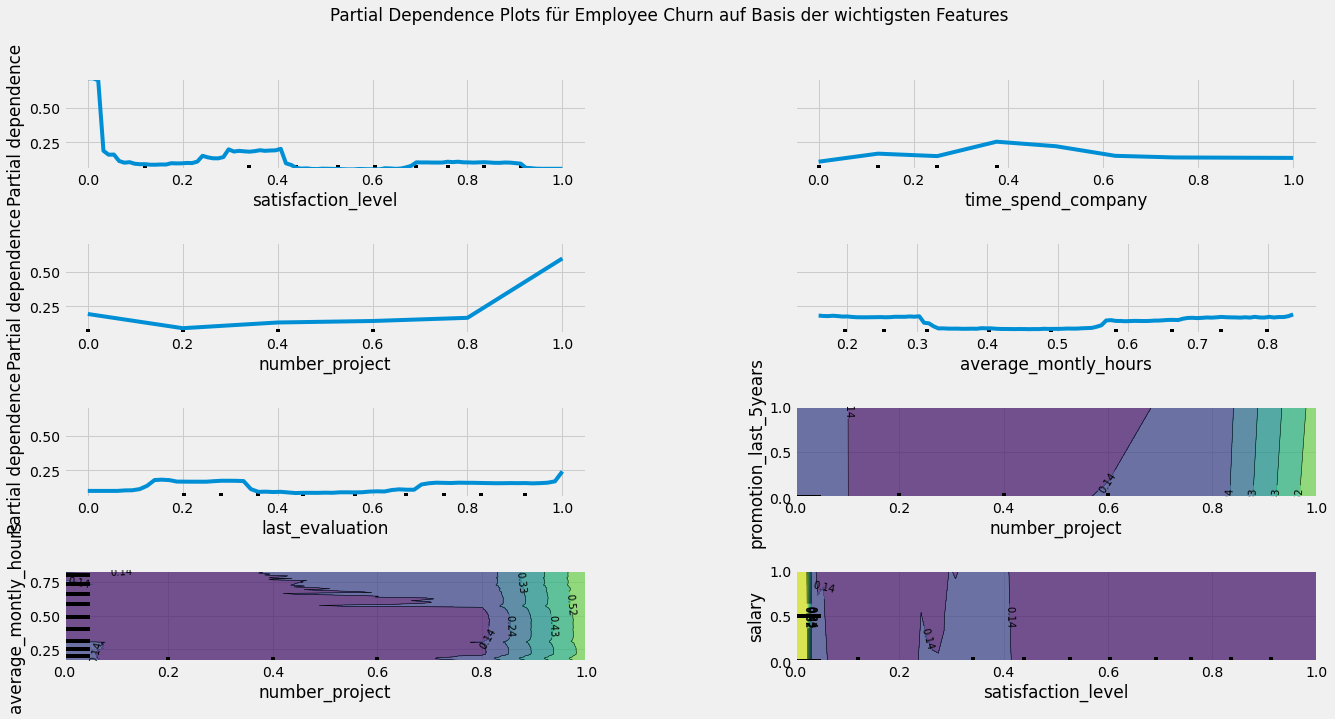

In [214]:
features = importances[0][:5] + [('number_project', 'promotion_last_5years')] + [('number_project', 'average_montly_hours')] + [('satisfaction_level', 'salary')]
print('Computing partial dependence plots...')
tic = time()
_, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
display = plot_partial_dependence(
    clf, X_train, features, n_jobs=-1, grid_resolution=100,
    ax=ax, n_cols = 100,
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial Dependence Plots für Employee Churn auf Basis der wichtigsten Features'
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.8)

1. Das Modell sagt eine hohe Kündigungswahrscheinlichkeit aus für geringe __Mitarbeiterzufriedenheit__. Fällt die Zufriedenheit unter 10%, gibt es eine sehr hohe Kündigungsprognose. Es gibt einen leichten Peak im mittleren Bereich um ca. 30%.

2. Für die __Beschäftigungsdauer__ gibt es einen Peak im mittleren Bereich von ca. 25%-60%. Hier lagen die meisten beobachteten Kündigungen.

3. Die partielle Abhängigkeit für eine Kündigung in Bezug auf die __Anzahl der Projekte__ verhält sich nahezu linear, bis zu einem Wert von ca. 80%. Ab da steigt die Kurve rasant an. Dies deckt sich mit den Analysen im Vorfeld. Zu stark ausgelastete Mitarbeiter neigen häufiger zu kündigen.

4. Die Abhängigkeitskurve für __monatlich geleistete Stunden__ verhält sich U-förmig: bei Werten unter 30% bzw. über 60% hebt sich Abhängigkeitskurve leicht.

5. Die kombinierte partielle Abhängigkeit von __Beförderungsquote und Anzahl der Projekte__ zeigt, dass die Kündigungswahrscheinlichkeit mit der Anzahl der Projekte tendenziell ansteigt.

## 4.4 SHAP (SHapley Additive exPlanations) Summary Plot

Wall time: 0 ns


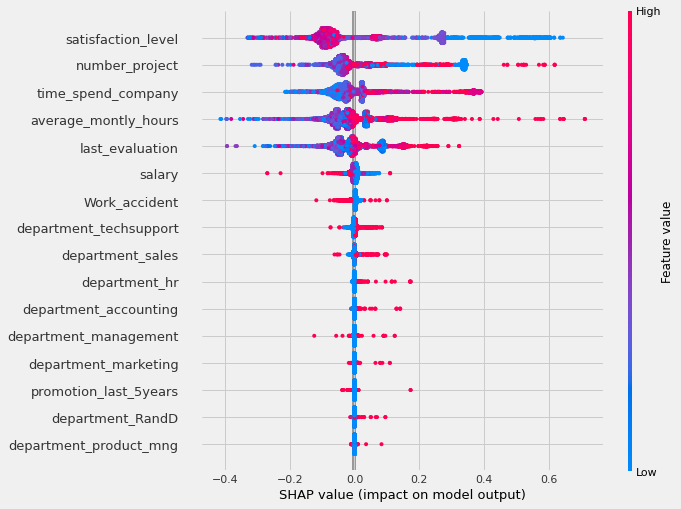

In [215]:
shap.initjs()

# Let us have a look on SHAP summary plot
%time
samples = X_train

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

shap.summary_plot(shap_values[1], samples)

1. Es gab eine hohe Mitarbeiterzufriedenheit in den Trainingsdaten (rote Ausprägung). Die hohe Mitarbeiterzufriedenheit bei einem Teil der Kündiger senkte die Prognose des Modells um -0.1 Punkte. Es gab auch einen wesentlichen Anteil mit geringer Mitarbeiterzufriedenheit, der die Prognose um ca. 0.3 angehoben hat.

2. Die Anzahl der Projekte ist verhältnismäßig ausgewogen, jedoch sorgt die bimodale Ausprägung in den Trainingsdaten, dass sich die Auswirkung auf die Prognose im Modell um -0.1 Punkte absenkend auswirkt.

3. Die übrigen Features unterhalb von salary werden praktisch fast ignoriert im Modell.

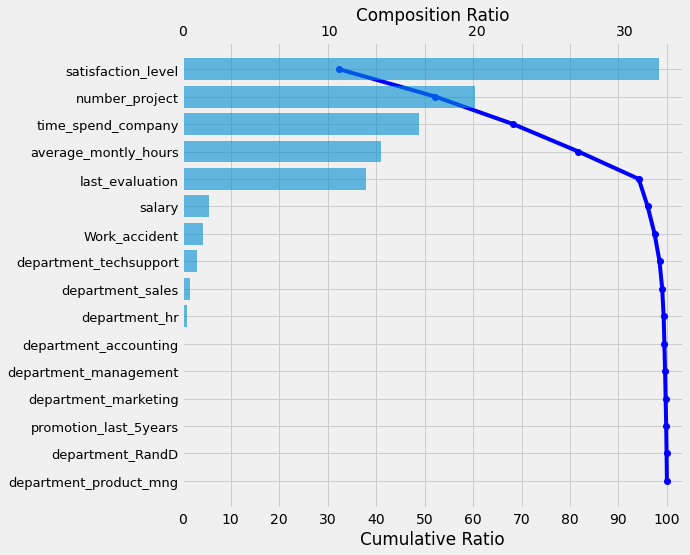

In [216]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))
    
    # Shap waterfall plot
make_shap_waterfall_plot(shap_values[1], samples)

Das SHAP Waterfall Plot zeigt, dass die Mitarbeiterzufriedenheit das wichtigste Feature im Modell ist. Es deckt mehr als 30% der Erklärbarkeit des Modells ab. An zweiter Stelle stehen die Anzahl der Projekte, die zu 20% beitragen. Die fünf wichtigsten Features tragen zu 95% zur Modellinterpretation bei.

## 4.5 Abweichungen

### 4.5.1 Fehler 1. Art

In [217]:
results[(results['left'] == 0) & (results['prediction'] == 1)]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,department_RandD,department_accounting,...,department_marketing,department_product_mng,department_sales,department_techsupport,left,prediction,probability,tree0_probability,tree1_probability,probability_tree_mean
7077,0.890110,0.765625,0.4,0.855140,0.500,0.0,0.0,0.5,0,0,...,0,0,0,1,0,1,0.735844,1.0,1.0,1.0
2095,0.494505,0.484375,0.4,0.869159,0.500,0.0,0.0,0.5,0,0,...,0,0,0,1,0,1,0.552120,0.0,1.0,0.5
5994,0.780220,0.984375,0.4,0.742991,0.375,1.0,0.0,0.0,0,0,...,0,0,0,1,0,1,0.900654,1.0,0.0,0.5
5565,0.824176,0.750000,0.8,0.771028,0.375,0.0,0.0,0.0,0,0,...,0,1,0,0,0,1,0.650850,1.0,0.0,0.5
5847,0.747253,0.765625,0.6,0.584112,0.375,0.0,0.0,0.0,0,0,...,0,0,0,1,0,1,0.990267,1.0,1.0,1.0
7004,0.835165,0.796875,0.8,0.635514,0.500,0.0,0.0,0.0,0,0,...,0,0,0,1,0,1,0.641482,1.0,0.0,0.5
7918,0.890110,0.703125,0.8,0.827103,0.375,0.0,0.0,0.5,0,0,...,0,0,0,1,0,1,0.598420,1.0,0.0,0.5


### 4.5.2 Fehler 2. Art

In [218]:
results[(results['left'] == 1) & (results['prediction'] == 0)]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,department_RandD,department_accounting,...,department_marketing,department_product_mng,department_sales,department_techsupport,left,prediction,probability,tree0_probability,tree1_probability,probability_tree_mean
1713,0.593407,0.890625,0.6,0.313084,0.125,0.0,0.0,0.5,0,0,...,0,0,0,0,1,0,0.002005,0.0,0.0,0.0
1162,0.285714,0.687500,0.8,0.864486,0.000,0.0,0.0,0.5,0,0,...,0,0,1,0,1,0,0.167982,0.0,0.0,0.0
14700,0.736264,0.812500,0.4,0.514019,0.250,0.0,0.0,0.5,0,0,...,0,0,0,0,1,0,0.154329,1.0,1.0,1.0
1289,0.373626,0.312500,0.8,0.247664,0.250,0.0,0.0,0.0,0,0,...,0,1,0,0,1,0,0.071619,0.0,0.0,0.0
1058,0.241758,0.921875,0.8,0.649533,0.375,0.0,0.0,0.0,0,0,...,0,1,0,0,1,0,0.245494,0.0,1.0,0.5
1601,0.648352,0.406250,0.6,0.476636,0.375,1.0,0.0,0.0,1,0,...,0,0,0,0,1,0,0.008328,0.0,0.0,0.0
818,0.879121,0.671875,0.2,0.247664,0.000,0.0,0.0,0.5,0,0,...,0,0,0,1,1,0,0.000142,0.0,0.0,0.0
1776,0.373626,0.171875,0.0,0.710280,0.000,0.0,0.0,0.5,0,0,...,0,0,1,0,1,0,0.104187,0.0,1.0,0.5
931,0.890110,0.875000,0.6,0.271028,0.250,0.0,0.0,0.0,0,0,...,0,0,1,0,1,0,0.027406,0.0,0.0,0.0
1411,0.252747,0.375000,0.0,0.859813,0.250,0.0,0.0,0.0,0,0,...,0,0,0,1,1,0,0.228065,0.0,0.0,0.0
